In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

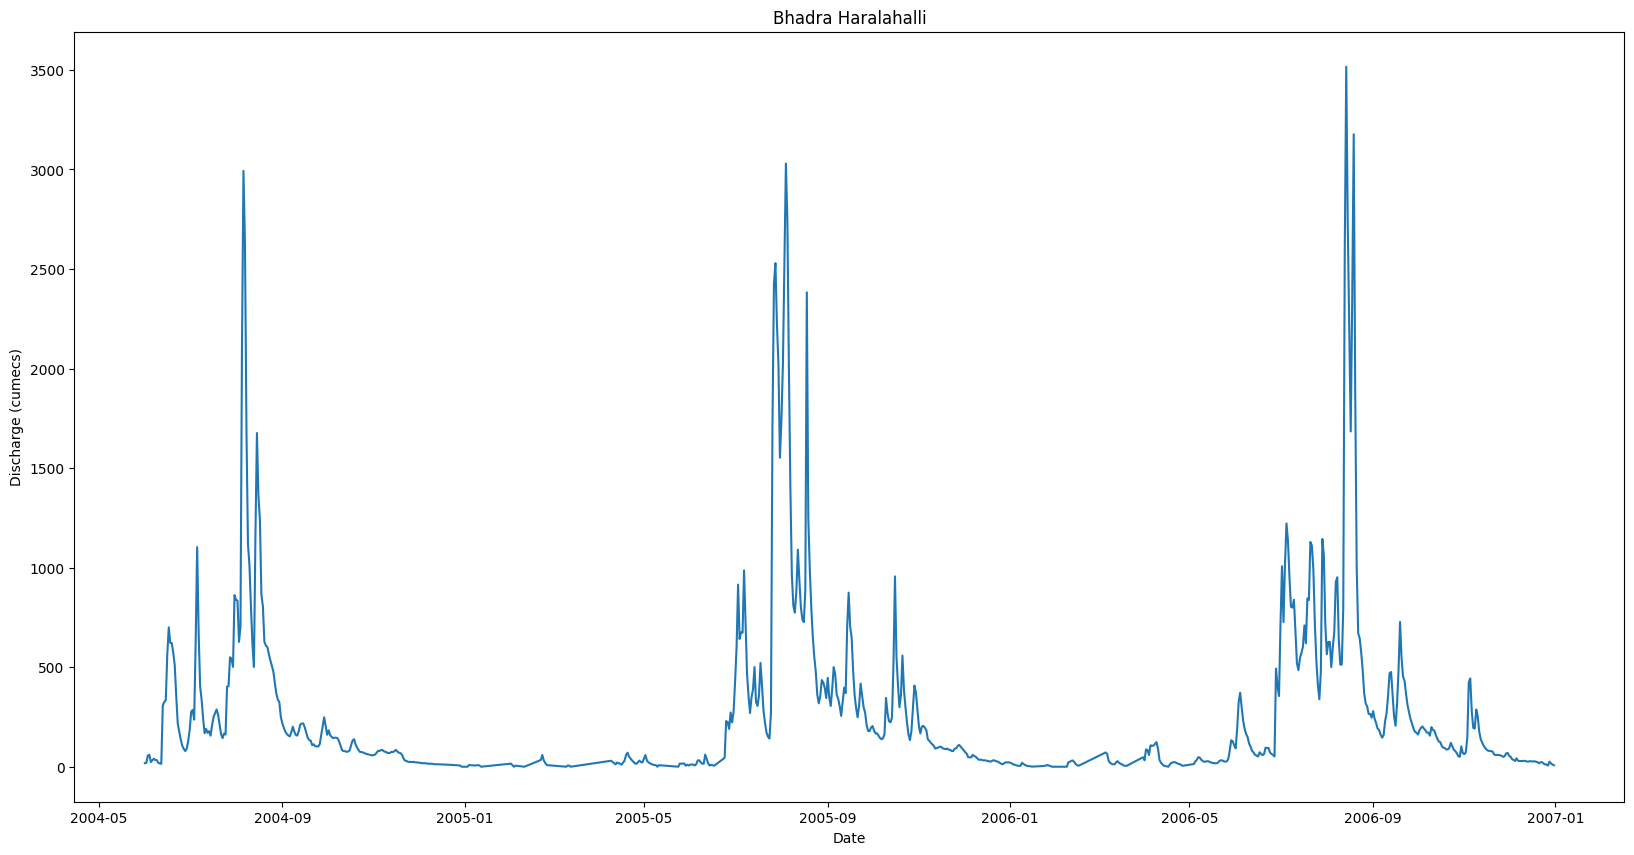

In [53]:
# Read data from csv file, data has 2 columns: Date and Discharge(cumsecs)
# Date is in dd/mm/yyyy format or dd-mm-yyyy format
# Some data values are missing or zero, use linear interpolation to fill them
df = pd.read_csv('./data/cleaned_data.csv', header=0, names=['Date', 'Discharge'])
# remove commas from discharge values and convert them to float
df['Discharge'] = df['Discharge'].str.replace(',', '').str.replace('"', '').astype(float)
# df['Discharge'] = df['Discharge'].replace(0, np.nan).interpolate(method='linear')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.set_index('Date')

# take values from June 2004 to December 2006
df = df.loc['2004-06-01':'2006-12-31']

# plot the data
plt.figure(figsize=(20, 10))
plt.plot(df['Discharge'])
plt.xlabel('Date')
plt.ylabel('Discharge (cumecs)')
plt.title('Bhadra Haralahalli')
plt.show()



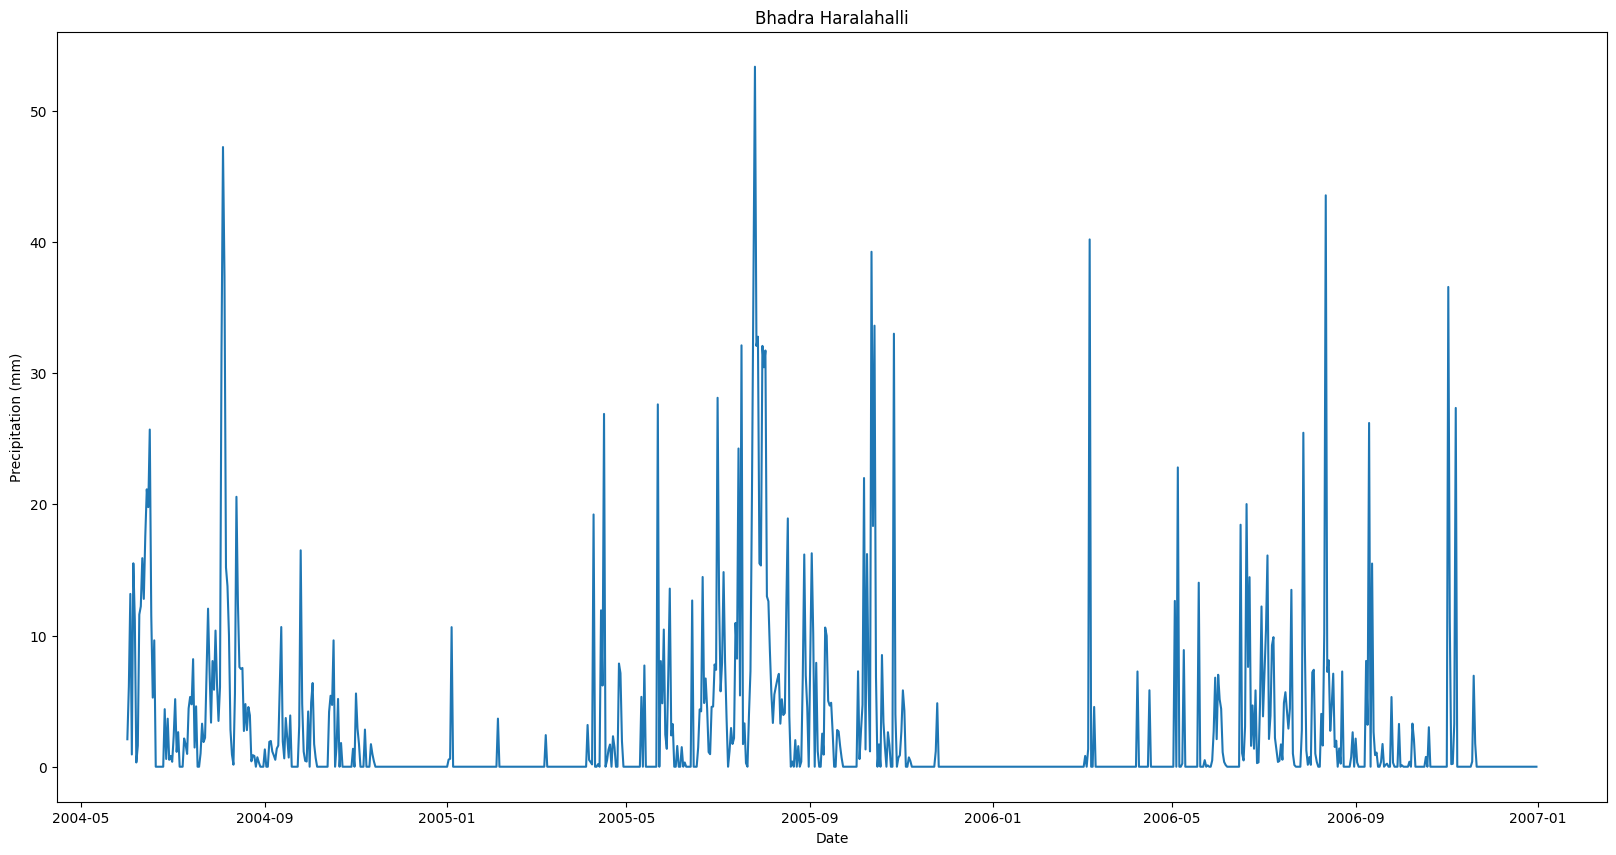

In [54]:
# Read data from csv file, data has 2 columns: Date and Precipitation(mm)
# Date is in yyyy-mm-dd format
precipitation_df = pd.read_csv('./data/precipitation_bhadra.csv', header=0, names=['Date', 'Precipitation'])
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y-%m-%d')
precipitation_df = precipitation_df.set_index('Date')

# take values from June 2004 to December 2006
precipitation_df = precipitation_df.loc['2004-06-01':'2006-12-31']

# plot the data
plt.figure(figsize=(20, 10))
plt.plot(precipitation_df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Bhadra Haralahalli')
plt.show()

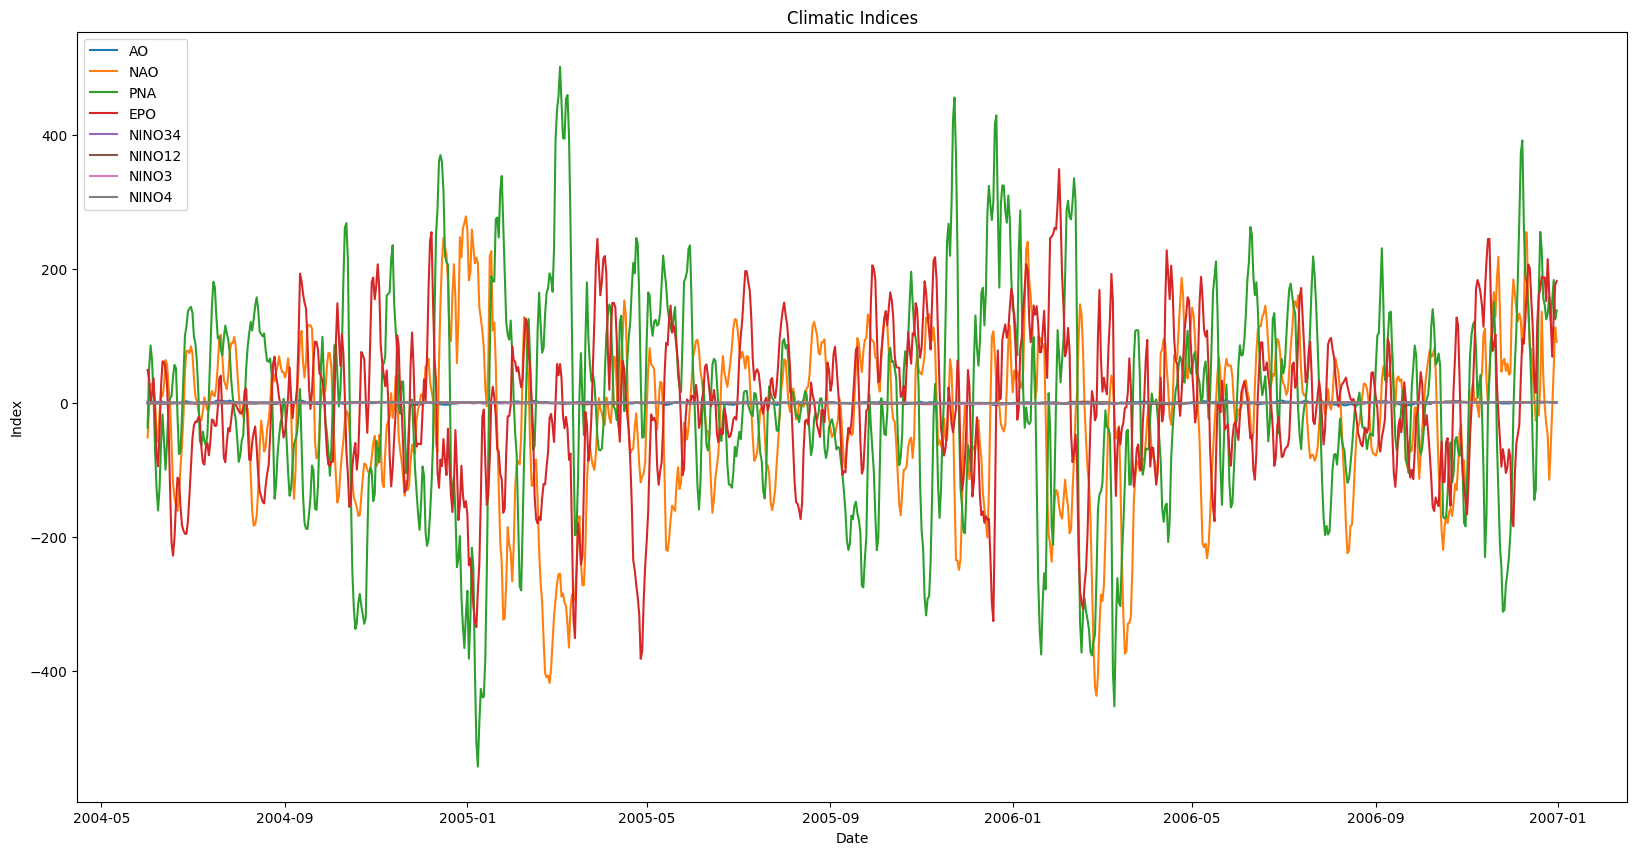

In [55]:
# read data from data.csv which has following columns - Date,AO,NAO,PNA,EPO,NINO34,NINO12,NINO3,NINO4
# Date is in yyyy-mm-dd format
climatic_df = pd.read_csv('./data/data.csv', header=0, names=['Date', 'AO', 'NAO', 'PNA', 'EPO', 'NINO34', 'NINO12', 'NINO3', 'NINO4'], parse_dates=['Date'])
climatic_df['Date'] = pd.to_datetime(climatic_df['Date'], format='%Y-%m-%d')
climatic_df = climatic_df.set_index('Date')

# take values from June 2004 to December 2006
climatic_df = climatic_df.loc['2004-06-01':'2006-12-31']

# plot the data
plt.figure(figsize=(20, 10))
plt.plot(climatic_df['AO'], label='AO')
plt.plot(climatic_df['NAO'], label='NAO')
plt.plot(climatic_df['PNA'], label='PNA')
plt.plot(climatic_df['EPO'], label='EPO')
plt.plot(climatic_df['NINO34'], label='NINO34')
plt.plot(climatic_df['NINO12'], label='NINO12')
plt.plot(climatic_df['NINO3'], label='NINO3')
plt.plot(climatic_df['NINO4'], label='NINO4')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Climatic Indices')
plt.show()

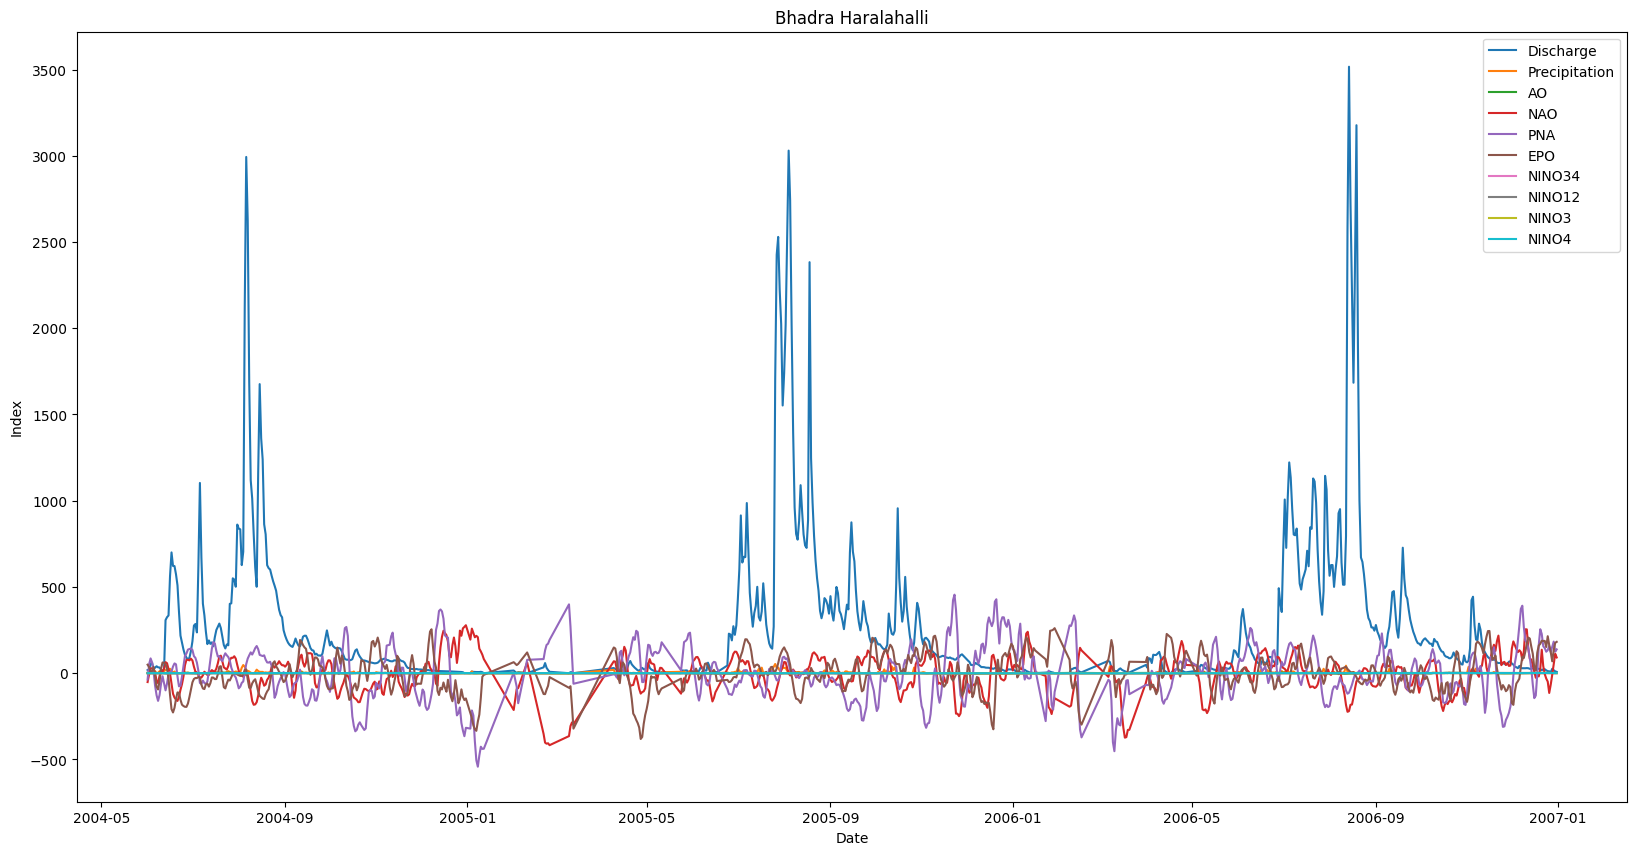

In [56]:
# merge discharge, precipitation and climatic data
df = pd.merge(df, climatic_df, how='inner', left_index=True, right_index=True)
df = pd.merge(df, precipitation_df, how='inner', left_index=True, right_index=True)

# plot the data
plt.figure(figsize=(20, 10))
plt.plot(df['Discharge'], label='Discharge')
plt.plot(df['Precipitation'], label='Precipitation')
plt.plot(df['AO'], label='AO')
plt.plot(df['NAO'], label='NAO')
plt.plot(df['PNA'], label='PNA')
plt.plot(df['EPO'], label='EPO')
plt.plot(df['NINO34'], label='NINO34')
plt.plot(df['NINO12'], label='NINO12')
plt.plot(df['NINO3'], label='NINO3')
plt.plot(df['NINO4'], label='NINO4')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Bhadra Haralahalli')
plt.show()

In [57]:
# Code for extracting important features

# Specify the threshold for feature importance
feature_importance_threshold = 0.01

# Function to perform feature extraction using Random Forest
def perform_feature_extraction(data, target_column):
    # Split the data into features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Random Forest regressor
    rf_regressor = RandomForestRegressor()

    # Train the Random Forest model
    rf_regressor.fit(X_train, y_train)

    # Get feature importance scores
    feature_importances = rf_regressor.feature_importances_

    # Create a DataFrame with feature names and their importance scores
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Select features above the threshold
    selected_features = feature_importance_df[feature_importance_df['Importance'] >= feature_importance_threshold]['Feature']

    # Display selected features
    print("Selected Features:")
    print(selected_features)

    return selected_features

# Example usage for Bhadra reservoir
bhadra_selected_features = perform_feature_extraction(df, 'Discharge')

Selected Features:
0               AO
1              NAO
2              PNA
3              EPO
4           NINO34
5           NINO12
6            NINO3
7            NINO4
8    Precipitation
Name: Feature, dtype: object


In [59]:
# Split data in to X and y
print(df)
y = df['Discharge']
X = df.drop('Discharge', axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)

# Make predictions using each model
rf_predictions = rf_model.predict(X_test)
gbr_predictions = gbr_model.predict(X_test)

# Combine predictions using Weighted Voting Ensemble Model (WVEM)
# Adjust weights based on the performance of each model
ensemble_predictions = (0.5 * rf_predictions) + (0.5 * gbr_predictions)

# Evaluate the ensemble model
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
print(f"Ensemble Model Mean Squared Error: {ensemble_mse}")

            Discharge     AO     NAO     PNA     EPO    NINO34    NINO12  \
Date                                                                       
2004-06-01      17.97  1.859  -51.48  -36.64   49.25  0.377649 -1.119204   
2004-06-02      19.44  2.268   -7.24   51.56   35.56  0.354378 -0.970147   
2004-06-03      56.36  2.177   27.21   85.64    3.45  0.295499 -0.916696   
2004-06-04      60.14  1.615   28.85   62.14   13.88  0.391359 -0.821221   
2004-06-05      23.81  1.337   23.66    8.42   36.74  0.497661 -0.862896   
...               ...    ...     ...     ...     ...       ...       ...   
2006-12-27       5.72  0.795  -66.68  122.09  122.84  1.155909  0.957484   
2006-12-28      25.46  0.270   -9.49  151.69   68.83  1.116228  0.959857   
2006-12-29      17.16  0.035   53.27  183.27  133.08  1.131670  0.904748   
2006-12-30      10.63  0.533  112.65  124.72  176.18  1.027061  0.830953   
2006-12-31       7.78  0.864   91.22  137.93  181.65  0.940010  0.796400   

           